# Generate Input Data

In [1]:
import numpy as np
import pandas as pd
import random
#Generate 5 random numbers between 10 and 30
np.random.seed(0)
n_samples=1000
n_features = 5
df_XY=pd.DataFrame(data = np.random.normal(0,1, size=(n_samples, n_features)), columns = ['A','B','C','D','E'])
df_XY['Y']=list(np.random.randint(2, size=n_samples))
df_XY['YY']=list(np.random.randint(2, size=n_samples))
df_XY

##############################################################   
df_XY.shape
df_XY.head()
df_XY.to_csv('df_XY.csv',index=False)
##############################################################

In [2]:
df_XY

,A,B,C,D,E,Y,YY
0,1.764052,0.400157,0.978738,2.240893,1.867558,1,1
1,-0.977278,0.950088,-0.151357,-0.103219,0.410599,0,0
2,0.144044,1.454274,0.761038,0.121675,0.443863,0,0
3,0.333674,1.494079,-0.205158,0.313068,-0.854096,1,0
4,-2.552990,0.653619,0.864436,-0.742165,2.269755,0,1
...,...,...,...,...,...,...,...
995,1.711489,-1.820816,0.163495,-0.813117,-0.605355,0,0
996,-1.327524,-0.644172,1.908883,-0.563545,1.082473,1,0
997,-1.951911,2.441216,-0.017285,0.912282,1.239658,1,1
998,-0.573367,0.424889,-0.271260,-0.683568,-1.537438,1,1


# Download CI-VAE, other necessary packages and Load Packages

In [3]:
! rm -rf ci_vae
! rm bb.pt
! rm bb_residuals.pkl
! rm df_reconstructed.csv
! rm df_reconstructed_decoder.csv
! rm residuals.pdf
! rm results_dict.pkl
! rm df_latent.csv

rm: df_reconstructed.csv: No such file or directory
rm: df_reconstructed_decoder.csv: No such file or directory
rm: results_dict.pkl: No such file or directory
rm: df_latent.csv: No such file or directory


In [4]:
! git clone https://github.com/monabiyan/ci_vae.git
! pip install umap-learn

Cloning into 'ci_vae'...
remote: Enumerating objects: 324, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 324 (delta 44), reused 57 (delta 22), pack-reused 245
Receiving objects: 100% (324/324), 46.73 MiB | 13.55 MiB/s, done.
Resolving deltas: 100% (200/200), done.


In [5]:
import pandas as pd
import numpy as np
import sklearn
import torch
import pickle

In [ ]:
#import umap

In [6]:
import matplotlib.pyplot as plt
from ci_vae import ivae

# Set Necessary Parameters 

In [7]:
model_init=True
model_tobe_trained=True
save_address="bb"

kl_coef = 0.0001
reconst_coef = 1
classifier_coef = 0.1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



# Initialize the Model

In [8]:
obj1 = ivae.IVAE(df_XY = df_XY,
               latent_size = 2,
               reconst_coef = reconst_coef,
               kl_coef = kl_coef,
               classifier_coef = classifier_coef,
               test_ratio = 1)

if model_init:
    obj1.model_initialiaze()

## See The Model Architecture

In [9]:
print(obj1.model)

IVAE_ARCH(
  (encoder): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(20, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (3): Dropout(p=0.05, inplace=False)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(20, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(20, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (11): Dropout(p=0.05, inplace=False)
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(20, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (15): Dropout(p=0.05, inplace=False)
    (16): Linear(in_features=20, out_features=20, bias=True)
    (17): ReLU()
    (18): BatchNorm1d(20, eps=1e-05, momentum=0.2, affine=Tru

## See the Initialized Weights

In [10]:
for param in obj1.model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.1255, -0.1332, -0.2631,  0.2878,  0.3824],
        [-0.1954, -0.2484, -0.1271, -0.1408, -0.3421],
        [-0.1822, -0.1539, -0.4439, -0.1395, -0.3040],
        [ 0.1568,  0.4452,  0.4382, -0.0129, -0.0811],
        [-0.2041, -0.2300, -0.3295, -0.3451,  0.2595],
        [ 0.3771,  0.1424, -0.2702, -0.4012,  0.3346],
        [ 0.0979,  0.2576, -0.3247, -0.1336,  0.0614],
        [-0.1357,  0.2861,  0.3238, -0.0621,  0.1341],
        [-0.4123, -0.3359, -0.4186,  0.2058, -0.2133],
        [ 0.3171, -0.0611, -0.0322, -0.2112,  0.1465],
        [ 0.1487, -0.2670,  0.3932, -0.1941, -0.1546],
        [-0.2165, -0.4302,  0.2742, -0.0267,  0.0773],
        [ 0.4455, -0.3335, -0.3291, -0.3714,  0.1650],
        [-0.2169,  0.0416,  0.0137,  0.1375,  0.1016],
        [-0.0674, -0.0214,  0.2815,  0.3504,  0.1888],
        [ 0.0246,  0.2687, -0.4299,  0.2854, -0.0239],
        [ 0.0086, -0.1917, -0.1670,  0.4021, -0.2057],
        [-0.0078, -0.0151,  0.3559, -0.3285

# RUN for Training

In [11]:
##########
if model_tobe_trained:
    lr=1e-2
    print(lr)
    obj1.model_training(epochs=100,learning_rate=lr)

    lr=1e-3
    print(lr)
    #obj.model_training(epochs=70,learning_rate=lr)

    lr=1e-3
    print(lr)
    #obj.model_training(epochs=200,learning_rate=lr)

    obj1.model_save(address=save_address+".pt")
    obj1.save_residuals(address=save_address+'_residuals.pkl')
    lr=1e-3
    print(lr)
    #obj.model_training(epochs=70,learning_rate=lr)

    lr=5e-4
    print(lr)
    obj1.model_training(epochs=50,learning_rate=lr)

    obj1.model_save(address=save_address+".pt")
    obj1.save_residuals(address=save_address+'_residuals.pkl')

    lr=1e-5
    print(lr)
    obj1.model_training(epochs=50,learning_rate=lr)

    lr=5e-6
    print(lr)
    obj1.model_training(epochs=50,learning_rate=lr)


0.01


/Users/mohsennabian/Desktop/ci_vae/example/ci_vae/ivae.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(torch.reshape(y, (-1,)), dtype=torch.long)
/Users/mohsennabian/Desktop/ci_vae/example/ci_vae/ivae.py:406: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(torch.reshape(y, (-1,)), dtype=torch.long)


====> Epoch: 1 total_train_loss: 1.002071 Total_test_loss: 0.878473 Total_BCE_test_loss: 0.793575 Total_KLD_test_loss: 0.000006 Total_CEP_test_loss: 0.084893
====> Epoch: 2 total_train_loss: 0.939039 Total_test_loss: 0.871801 Total_BCE_test_loss: 0.790666 Total_KLD_test_loss: 0.000002 Total_CEP_test_loss: 0.081133
====> Epoch: 3 total_train_loss: 0.921352 Total_test_loss: 0.871313 Total_BCE_test_loss: 0.789073 Total_KLD_test_loss: 0.000003 Total_CEP_test_loss: 0.082236
====> Epoch: 4 total_train_loss: 0.901816 Total_test_loss: 0.864607 Total_BCE_test_loss: 0.788611 Total_KLD_test_loss: 0.000008 Total_CEP_test_loss: 0.075989
====> Epoch: 5 total_train_loss: 0.890170 Total_test_loss: 0.864015 Total_BCE_test_loss: 0.788591 Total_KLD_test_loss: 0.000012 Total_CEP_test_loss: 0.075412
====> Epoch: 6 total_train_loss: 0.889733 Total_test_loss: 0.864211 Total_BCE_test_loss: 0.789090 Total_KLD_test_loss: 0.000019 Total_CEP_test_loss: 0.075102
====> Epoch: 7 total_train_loss: 0.885155 Total_test

====> Epoch: 56 total_train_loss: 0.690416 Total_test_loss: 0.654416 Total_BCE_test_loss: 0.582443 Total_KLD_test_loss: 0.002576 Total_CEP_test_loss: 0.069396
====> Epoch: 57 total_train_loss: 0.689695 Total_test_loss: 0.649959 Total_BCE_test_loss: 0.578014 Total_KLD_test_loss: 0.002582 Total_CEP_test_loss: 0.069363
====> Epoch: 58 total_train_loss: 0.685463 Total_test_loss: 0.648722 Total_BCE_test_loss: 0.576813 Total_KLD_test_loss: 0.002629 Total_CEP_test_loss: 0.069280
====> Epoch: 59 total_train_loss: 0.688819 Total_test_loss: 0.649671 Total_BCE_test_loss: 0.577731 Total_KLD_test_loss: 0.002642 Total_CEP_test_loss: 0.069298
====> Epoch: 60 total_train_loss: 0.682691 Total_test_loss: 0.644206 Total_BCE_test_loss: 0.572233 Total_KLD_test_loss: 0.002671 Total_CEP_test_loss: 0.069302
====> Epoch: 61 total_train_loss: 0.679948 Total_test_loss: 0.642990 Total_BCE_test_loss: 0.570933 Total_KLD_test_loss: 0.002736 Total_CEP_test_loss: 0.069321
====> Epoch: 62 total_train_loss: 0.675042 Tot

====> Epoch: 11 total_train_loss: 0.641997 Total_test_loss: 0.594950 Total_BCE_test_loss: 0.522203 Total_KLD_test_loss: 0.003464 Total_CEP_test_loss: 0.069284
====> Epoch: 12 total_train_loss: 0.640105 Total_test_loss: 0.596204 Total_BCE_test_loss: 0.523485 Total_KLD_test_loss: 0.003431 Total_CEP_test_loss: 0.069287
====> Epoch: 13 total_train_loss: 0.645811 Total_test_loss: 0.595430 Total_BCE_test_loss: 0.522720 Total_KLD_test_loss: 0.003421 Total_CEP_test_loss: 0.069289
====> Epoch: 14 total_train_loss: 0.644112 Total_test_loss: 0.594886 Total_BCE_test_loss: 0.522173 Total_KLD_test_loss: 0.003422 Total_CEP_test_loss: 0.069291
====> Epoch: 15 total_train_loss: 0.643866 Total_test_loss: 0.594227 Total_BCE_test_loss: 0.521503 Total_KLD_test_loss: 0.003428 Total_CEP_test_loss: 0.069295
====> Epoch: 16 total_train_loss: 0.641863 Total_test_loss: 0.594581 Total_BCE_test_loss: 0.521847 Total_KLD_test_loss: 0.003433 Total_CEP_test_loss: 0.069301
====> Epoch: 17 total_train_loss: 0.643761 Tot

====> Epoch: 15 total_train_loss: 0.634835 Total_test_loss: 0.589464 Total_BCE_test_loss: 0.516645 Total_KLD_test_loss: 0.003514 Total_CEP_test_loss: 0.069305
====> Epoch: 16 total_train_loss: 0.637767 Total_test_loss: 0.589715 Total_BCE_test_loss: 0.516857 Total_KLD_test_loss: 0.003551 Total_CEP_test_loss: 0.069306
====> Epoch: 17 total_train_loss: 0.634545 Total_test_loss: 0.591168 Total_BCE_test_loss: 0.518371 Total_KLD_test_loss: 0.003491 Total_CEP_test_loss: 0.069307
====> Epoch: 18 total_train_loss: 0.636540 Total_test_loss: 0.590711 Total_BCE_test_loss: 0.517917 Total_KLD_test_loss: 0.003488 Total_CEP_test_loss: 0.069306
====> Epoch: 19 total_train_loss: 0.636434 Total_test_loss: 0.590334 Total_BCE_test_loss: 0.517542 Total_KLD_test_loss: 0.003488 Total_CEP_test_loss: 0.069304
====> Epoch: 20 total_train_loss: 0.636636 Total_test_loss: 0.590048 Total_BCE_test_loss: 0.517240 Total_KLD_test_loss: 0.003502 Total_CEP_test_loss: 0.069305
====> Epoch: 21 total_train_loss: 0.637174 Tot

====> Epoch: 17 total_train_loss: 0.638170 Total_test_loss: 0.589877 Total_BCE_test_loss: 0.517047 Total_KLD_test_loss: 0.003524 Total_CEP_test_loss: 0.069305
====> Epoch: 18 total_train_loss: 0.637261 Total_test_loss: 0.589696 Total_BCE_test_loss: 0.516883 Total_KLD_test_loss: 0.003508 Total_CEP_test_loss: 0.069305
====> Epoch: 19 total_train_loss: 0.639923 Total_test_loss: 0.588863 Total_BCE_test_loss: 0.516049 Total_KLD_test_loss: 0.003509 Total_CEP_test_loss: 0.069305
====> Epoch: 20 total_train_loss: 0.640611 Total_test_loss: 0.589226 Total_BCE_test_loss: 0.516386 Total_KLD_test_loss: 0.003538 Total_CEP_test_loss: 0.069303
====> Epoch: 21 total_train_loss: 0.636216 Total_test_loss: 0.589446 Total_BCE_test_loss: 0.516617 Total_KLD_test_loss: 0.003524 Total_CEP_test_loss: 0.069306
====> Epoch: 22 total_train_loss: 0.637791 Total_test_loss: 0.589744 Total_BCE_test_loss: 0.516932 Total_KLD_test_loss: 0.003508 Total_CEP_test_loss: 0.069304
====> Epoch: 23 total_train_loss: 0.634567 Tot

# Save The Trained Model

In [12]:
##########
print("running the neural network")
#run(obj1,save_address)
obj1.model_save(address=save_address+".pt")
obj1.save_residuals(address=save_address+'_residuals.pkl')

running the neural network
model saved


# Visualize Residuals

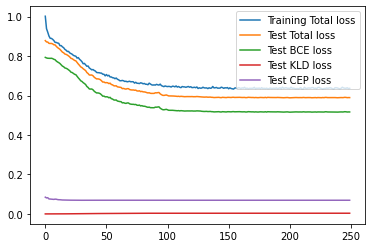

<Figure size 432x288 with 0 Axes>

In [13]:
obj1.plot_residuals(init_index=0)

# Load Model and Data

In [14]:
from ci_vae import ivae
import pandas as pd
import numpy as np
import sklearn
import torch
#import umap
import pickle
import matplotlib.pyplot as plt

In [15]:
print("start of the code")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##############################################################   
##############################################################
model_init=True
model_tobe_trained=False

model_init=True
model_file_address='./bb.pt'
save_address1="./"

df_XY=pd.read_csv('df_XY.csv')

start of the code


## Load Saved Model

In [26]:
obj2 = ivae.IVAE(df_XY = df_XY,
               reconst_coef = reconst_coef,
               latent_size = 10,
               kl_coef = kl_coef,
               classifier_coef = classifier_coef,
               test_ratio = 1)

obj2.model_initialiaze()

obj2.model_load(address="bb.pt")

TypeError: cannot assign 'dict' as child module 'model' (torch.nn.Module or None expected)

## Print the Weights

In [20]:
for param in obj2.model.parameters():
    print(param)

AttributeError: 'dict' object has no attribute 'parameters'

# Make Prediction of All Test Data

In [22]:
with torch.no_grad():
    obj2.model.eval()

    obj2.load_residuals(address='bb_residuals.pkl')
    print("model loaded")
    
    obj2.generate_test_results()
    print("test data generated")

AttributeError: 'dict' object has no attribute 'eval'

# Comprehensive Checking of The Prediction Values vs. True Values. 

In [23]:
print(obj2.x_last)

AttributeError: 'IVAE' object has no attribute 'x_last'

In [ ]:
print(obj2.x_pred)

In [ ]:
(np.abs(obj2.x_pred - obj2.x_last)).mean()

In [ ]:
(obj2.x_pred-obj2.x_last)

In [ ]:
print(obj2.y_last)

In [ ]:
print(obj2.y_pred)

In [ ]:
df_XY

In [ ]:
with torch.no_grad():
    obj2.model.eval()
    for x, y in obj2.testloader:
      x = x.to(device)
      print(x.size())
      print(x)
      # forward
      x_hat,y_hat, mu, logvar,z = obj2.model(x)
    
    df_reconstructed = pd.DataFrame(x_hat.cpu().detach().numpy(), columns=obj2.df_XY.drop(columns=['Y']).columns)
    print(df_reconstructed.shape)
    df_latent=pd.DataFrame(z.cpu().detach().numpy())
    
    obj2.model.eval()
    
    df_reconstructed_decoder=pd.DataFrame(obj2.model.decoder(z).cpu().detach().numpy(), columns=obj2.df_XY.drop(columns=['Y']).columns)

    df_reconstructed.to_csv('df_reconstructed.csv')
    df_latent.to_csv('df_latent.csv')
    df_reconstructed_decoder.to_csv('df_reconstructed_decoder.csv')
    print("Full_data_reconstructed...")
    
    print("========df_reconstructed========")
    print(df_reconstructed)
    print("========df_reconstructed_decoder========")
    print(df_reconstructed_decoder)
    print("========df_Original========")
    print(df_XY)
    
    
    


# Checking Linear Separability of Data on Lower Dimensioanl Space

In [ ]:
print("regression analysis")
obj2.regression_analysis(obj2.zs,df_XY['Y'])

# Visualize Data on Lower Dimensional Space

In [ ]:
print("calculate tsne_umap_pca")
tsne_mat,umap_mat,pca_mat,Y=obj2.calculate_lower_dimensions(obj2.zs,obj2.y_last,N=100)
obj2.plot_lower_dimension(tsne_mat,Y,projection='3d',save_str='tsne3d.pdf')
obj2.plot_lower_dimension(tsne_mat,Y,projection='2d',save_str='tsne2d.pdf')
obj2.plot_lower_dimension(umap_mat,Y,projection='3d',save_str='umap3d.pdf')
obj2.plot_lower_dimension(umap_mat,Y,projection='2d',save_str='umap2d.pdf')
obj2.plot_lower_dimension(pca_mat,Y,projection='3d',save_str='pca3d.pdf')
obj2.plot_lower_dimension(pca_mat,Y,projection='2d',save_str='pca2d.pdf')

print("finished")


# Perform Interpolation across all groups (Y) and all features from YY=0 to YY=1

In [ ]:
ff = obj2.traversal_all_groups(traversal_step=5)

# See the interpolation results

In [ ]:
with open('results_dict.pkl', 'rb') as f:
    ff = pickle.load(f)

In [ ]:
ff['med']['0']

In [ ]:
ff['mean']['1']

In [ ]:
plt.plot(ff['med']['1']['B'])

In [ ]:
plt.plot(ff['mean']['1']['B'])

In [ ]:
plt.plot(ff['med']['0']['C'])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(ff['mean']['0']['C'])

# Generate Synthetic Data for a Given Class

In [ ]:
bb = obj2.synthetic_single_group(group_id=0,nr_of_synthetic=1000)

In [ ]:
bb.shape

In [ ]:
bb